In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
import random
import pprint
from sklearn.metrics.pairwise import euclidean_distances

pp = pprint.PrettyPrinter(indent=0)
%matplotlib inline
sns.set()

samples_to_show = 3
samples_to_generate = 1000000
gender_weight = 50
comorbidity_suffix = '_comorbidity'

In [2]:
firstnames = [name.strip().capitalize() for name in open('firstnames.txt', 'r').readlines()]
lastnames = [name.strip().capitalize() for name in open('lastnames.txt', 'r').readlines()]

symptoms = [
    'anhedonia',
    'fatigue',
    'appetite_weight',
    'depressed_mood',
    'worthlessness_guilt',
    'suicide',
    ]

comorbidities = [symptom + comorbidity_suffix for symptom in symptoms]

treatments = [
    'CBT',
    'SSRI',
    'SNRI',
    'ECT',
    ]

patients = []
id_counter = 0

def generate_patient(with_treatment_outcomes=True):
    global id_counter
    
    d = {
        'patient_id': id_counter,
        'name': '{} {}'.format(random.choice(firstnames), random.choice(lastnames)),
        'age': random.randint(10,110),
        # 0 - Female
        # 1 - Male
        'gender': random.randint(0,1) * gender_weight,
    }

    # 0 - Does not exhibit symptom
    # 100 - Maximum exhibition of symptom
    d.update({symptom: random.randint(0,100) for symptom in symptoms})
    
    # 0 - Has comorbid symptom
    # 1 - Does not have comorbid symptom
    d.update({comorbidity: random.randint(0,1) for comorbidity in comorbidities})
    
    if with_treatment_outcomes:
        # None - Treatment has not been tried
        # 0 - Treatment not effective
        # 1 - Treatment mildly effective
        # 2 - Treatment highly effective
        d.update({treatment: random.choice(list(range(3)) + [None]) for treatment in treatments})
    else:
        d.update({treatment: None for treatment in treatments})
        
    id_counter += 1
    
    return d
    
# Generate sample patient data
for patient in range(samples_to_generate):
    d = generate_patient()
    patients += [d]

In [3]:
df = pd.DataFrame(patients)
df = df[['patient_id','name', 'age', 'gender'] + symptoms + comorbidities + treatments]
df.head(samples_to_show)

def show_head_inorder(df):
    df = df[['patient_id','name', 'age', 'gender'] + symptoms + comorbidities + treatments]
    return(df.head(samples_to_show))

show_head_inorder(df)

,patient_id,name,age,gender,anhedonia,fatigue,appetite_weight,depressed_mood,worthlessness_guilt,suicide,anhedonia_comorbidity,fatigue_comorbidity,appetite_weight_comorbidity,depressed_mood_comorbidity,worthlessness_guilt_comorbidity,suicide_comorbidity,CBT,SSRI,SNRI,ECT
0,0,Corette Mao,63,0,10,8,53,1,0,66,1,1,1,0,1,1,0.0,0.0,1.0,2.0
1,1,Emogene Chaney,68,50,36,52,24,24,89,55,0,1,0,1,0,0,0.0,1.0,0.0,2.0
2,2,Janessa Epps,64,50,27,63,38,18,83,83,0,0,0,0,1,1,2.0,2.0,NaN,NaN


In [4]:
def draw_radar(patient_id, patient2_id=None):
    # Refresh df
    df = pd.DataFrame(patients)
    df = df[['patient_id','name', 'age', 'gender'] + symptoms + comorbidities + treatments]
    
    labels = np.array(symptoms)
    comorbidity_labels = np.array(comorbidities)
    
    stats = df.loc[patient_id, labels].values
    comorbidity_stats = df.loc[patient_id, comorbidity_labels].values
    
    #print(comorbidity_stats)
    labelnames = [symptoms[i] + '[1]' if comorbidity_stats[i] else symptoms[i] for i in range(len(symptoms))]

    # Reference - https://www.kaggle.com/typewind/draw-a-radar-chart-with-python-in-a-simple-way
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    stats = np.concatenate((stats, [stats[0]]))
    angles = np.concatenate((angles, [angles[0]]))

    fig = plt.figure()

    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats, 'o-', linewidth=1)
    ax.fill(angles, stats, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, labelnames)
    ax.set_title([df.loc[patient_id,"name"]][0])
    ax.set_ylim(0, 100)
    ax.grid(True)
    
    if patient2_id:
        stats2 = df.loc[patient2_id, labels].values
        stats2 = np.concatenate((stats2, [stats2[0]]))
        comorbidity_stats2 = df.loc[patient2_id, comorbidity_labels].values
        
        labelnames = [labelnames[i] + '[2]' if comorbidity_stats2[i] else labelnames[i] for i in range(len(symptoms))]
        
        ax.plot(angles, stats2, 'o-', linewidth=1)
        ax.fill(angles, stats2, alpha=0.25, color='green')
        
        p1_gender = 'm' if [df.loc[patient_id,"gender"]][0] > 0 else 'f'
        p2_gender = 'm' if [df.loc[patient2_id,"gender"]][0] > 0 else 'f'
        ax.set_title("{} ({}{}, Blue), {} ({}{}, Green)".format([df.loc[patient_id,"name"]][0], 
                                                                  [df.loc[patient_id,"age"]][0],
                                                                  p1_gender,
                                                                  [df.loc[patient2_id,"name"]][0],
                                                                  [df.loc[patient2_id,"age"]][0],
                                                                  p2_gender,
                                                                  )
                    )
        ax.set_thetagrids(angles * 180/np.pi, labelnames)

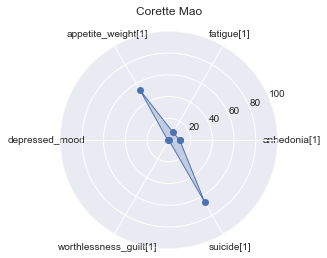

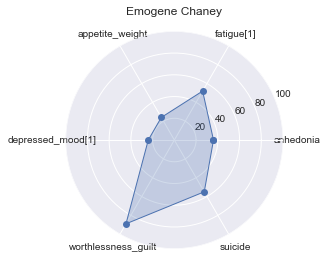

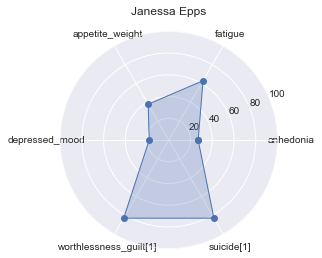

In [5]:
# Uncomment below line to show radar charts
for patient_id in range(samples_to_show): draw_radar(patient_id)

In [6]:
# Create a patient who has not year been treated
untreated_patient = generate_patient(with_treatment_outcomes=False)
patients += [untreated_patient]

In [7]:
patients_data = [[patient[key] for key in symptoms + ['age', 'gender']] for patient in patients]
patients_info = [[patient[key] for key in comorbidities + treatments + ['name', 'patient_id']] for patient in patients]
untreated_patients_data = [[untreated_patient[key] for key in symptoms + ['age', 'gender']]]
untreated_patients_info = [[untreated_patient[key] for key in comorbidities + treatments + ['name', 'patient_id']]]

In [8]:
# Find other patients and their outcomes who have attributes similar to the new patient.
# Output dict format: 
# {attribute1: [similar_patient_value, new_patient_value],
#  attribute2: ...}
def find_similar_cases(similar_cases_to_show, untreated_patients_data, untreated_patients_info):
    untreated_patients_combined = untreated_patients_info[0] + untreated_patients_data[0]
    similarity = euclidean_distances(untreated_patients_data, patients_data).tolist()[0]
    cases = []

    for case in range(samples_to_show):
        most_similar = min(similarity)
        idx = similarity.index(most_similar)
        similarity.remove(most_similar)
        most_similar = patients_info[idx] + patients_data[idx] + [most_similar]
        field_names = comorbidities + treatments + ['name', 'patient_id'] + symptoms + ['age', 'gender'] 
        case = {field_names[i]: [most_similar[i], untreated_patients_combined[i]] for i in range(len(untreated_patients_combined))}
        # Lower is better
        case['similarity_score'] = round(most_similar[-1], 2)
        cases += [case]
        
    return cases

similar_cases = find_similar_cases(samples_to_show, untreated_patients_data, untreated_patients_info)
pp.pprint(similar_cases)

[{'CBT': [None, None],
'ECT': [None, None],
'SNRI': [None, None],
'SSRI': [None, None],
'age': [40, 40],
'anhedonia': [37, 37],
'anhedonia_comorbidity': [1, 1],
'appetite_weight': [78, 78],
'appetite_weight_comorbidity': [0, 0],
'depressed_mood': [74, 74],
'depressed_mood_comorbidity': [0, 0],
'fatigue': [21, 21],
'fatigue_comorbidity': [0, 0],
'gender': [50, 50],
'name': ['Jere Nickoloff', 'Jere Nickoloff'],
'patient_id': [1000000, 1000000],
'similarity_score': 0.0,
'suicide': [75, 75],
'suicide_comorbidity': [1, 1],
'worthlessness_guilt': [79, 79],
'worthlessness_guilt_comorbidity': [1, 1]},
{'CBT': [0, None],
'ECT': [0, None],
'SNRI': [None, None],
'SSRI': [None, None],
'age': [43, 40],
'anhedonia': [32, 37],
'anhedonia_comorbidity': [1, 1],
'appetite_weight': [79, 78],
'appetite_weight_comorbidity': [0, 0],
'depressed_mood': [69, 74],
'depressed_mood_comorbidity': [1, 0],
'fatigue': [13, 21],
'fatigue_comorbidity': [1, 0],
'gender': [50, 50],
'name': ['Barbra Zirilli', 'Jere Nickol

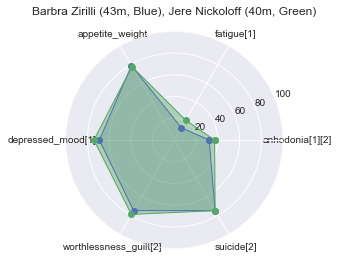

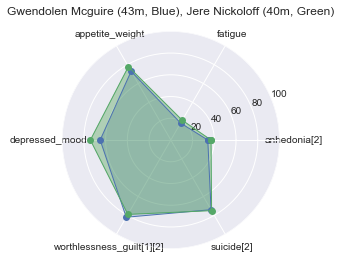

In [9]:
for similar_case in similar_cases[1:]:
    case = similar_case['patient_id']
    patient, patient2 = case[0], case[1]
    draw_radar(patient, patient2)

In [10]:
map_treatment_outcomes = {
    None: 'Unknown/Not tried',
    0.0: 'Not effective',
    1.0: 'Somewhat effective',
    2.0: 'Highly effective',
}

closest_match = similar_cases[1]

for treatment in treatments:
    closest_match[treatment] = [map_treatment_outcomes[closest_match[treatment][0]], map_treatment_outcomes[closest_match[treatment][1]]]

In [11]:
#pp.pprint(closest_match)

df2 = pd.DataFrame(closest_match)
show_head_inorder(df2)

,patient_id,name,age,gender,anhedonia,fatigue,appetite_weight,depressed_mood,worthlessness_guilt,suicide,anhedonia_comorbidity,fatigue_comorbidity,appetite_weight_comorbidity,depressed_mood_comorbidity,worthlessness_guilt_comorbidity,suicide_comorbidity,CBT,SSRI,SNRI,ECT
0,692924,Barbra Zirilli,43,50,32,13,79,69,75,75,1,1,0,1,0,0,Not effective,Unknown/Not tried,Unknown/Not tried,Not effective
1,1000000,Jere Nickoloff,40,50,37,21,78,74,79,75,1,0,0,0,1,1,Unknown/Not tried,Unknown/Not tried,Unknown/Not tried,Unknown/Not tried
